# NLP Tutorial: Basic Text Processing and Analysis

## Introduction

Natural Language Processing (NLP) is a subfield of artificial intelligence that focuses on enabling computers to understand and interpret human language. NLP is becoming increasingly important as text data continues to grow in variety and volume, from social media and news articles to scientific papers and business communications.

In this tutorial, we will explore basic NLP techniques that form the foundation for more advanced text analysis. These techniques include **term frequency (TF), TF-IDF, n-grams,** and **sentiment analysis**. We will also touch on an important concept in linguistics called Zipf's Law, which provides insights into how words are distributed in natural language.

Zipf's Law states that in any given text or language, the frequency of a word is inversely proportional to its rank in the frequency table. This means that a few words (like "the," "of," or "and") will occur very frequently, while the vast majority of words will appear only a few times. This concept is critical to understanding the distribution of word frequencies and can help inform decisions about text processing, such as which words to focus on for feature extraction or which words to consider as stopwords.

For example, let's look at a plot of word frequency distribution which follows Zipf's Law. You'll notice that a few words dominate the distribution, while most words appear infrequently.

![](https://www.etymologynerd.com/uploads/1/5/8/8/15888322/website.png)

This plot demonstrates how the frequency of words declines exponentially as their rank increases, illustrating Zipf’s Law in practice. In text analysis, recognizing this pattern can guide decisions about which words to focus on, especially when creating features for models.

Now that we've set the stage, let's dive into the main topics of this tutorial. First, we'll revisit the data scraping from the [W7-Scraping](https://colab.research.google.com/drive/1n-TfXIhfus0FlDH4teAgXFOIYbQJAkbA?usp=sharing) tutorial to build out an "OpenAlex" textual dataset on "biocultural restoration" scientific studies.

In [ ]:
! pip install pyalex # install the OpenAlex Python wrapper package

In [ ]:
### Import the PyAlex package and functions
import pyalex
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders
from pyalex import config

### Import additional packages that we will need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### NLP packages we need
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('vader_lexicon')
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
### Provide your email address so that you can enter the "polite pool"
### and get much more rapid request delivery
### FMI: https://docs.openalex.org/how-to-use-the-api/rate-limits-and-authentication#the-polite-pool
pyalex.config.email = "cecil.sagehen47@pomona.edu" # replace with your email

In [ ]:
### Specify some controls for the API querying
### such as how many times you will retry a failed request
config.max_retries = 3
config.retry_backoff_factor = 0.1
config.retry_http_codes = [429, 500, 503]

In [ ]:
### Query for studies that include the term "biocultural restoration"
### in the abstract field. By default, this returns only 25 results

### Combining elements of the W7 tutorial, we will build a slightly larger dataset with 100 studies
### Recall that to do so, we need to instantiate a cursor or pager to "page" through results

### Initialize a pager
pager = Works().search_filter(abstract="biocultural restoration").paginate(method="page",per_page=25, n_max=100) # keep this small and toy, n_max=100

In [ ]:
### Collect all results
all_results = []
for page in pager:
  all_results.extend(page) # Concatenate to the initially empty list (then add to existing list) of studies from the current page (e.g. 0-25, 26-50, 51-75, etc.)

In [ ]:
### Convert this set of results to a larger pandas DataFrame
biocultural_big = pd.DataFrame(all_results)

In [ ]:
### Display our results - controls
pd.set_option('display.max_columns',55)
# pd.reset_option('display.max_columns') # uncomment to reset to default

In [ ]:
### Inspect our data
biocultural_big.abstract_inverted_index.head(5)

,abstract_inverted_index
0,"{'Through': [0], 'research,': [1], 'restoratio..."
1,"{'Social-ecological': [0], 'system': [1, 31], ..."
2,"{'As': [0], 'an': [1, 48], 'introduction': [2]..."
3,"{'A': [0], 'pluralist': [1], 'and': [2, 13, 29..."
4,"{'Human': [0], 'activity': [1], 'has': [2, 16,..."


## Step 1: Convert Abstract Inverted Index to Full Text

Many NLP datasets, especially large ones, store text in compressed forms like an inverted index ([FMI here](https://en.wikipedia.org/wiki/Inverted_index)). This is an efficient way to store and search for words across multiple documents. However, to perform analysis on the actual text, we often need to convert these compact representations back into plain text.

For example, the `abstract_inverted_index` field might look like this:

```json
{
    "Through": [0],
    "research": [1],
    "restoration": [2],
    "biodiversity": [3]
}
```

The goal is to convert this inverted index back to its original text form, where words are arranged in the order they appear in the document.

To do this, we will extract the keys (the words) from the inverted index and join them together into a single string of text.

```python
# Sample inverted index data
sample_inverted_index = {
    "Through": [0],
    "research": [1],
    "restoration": [2],
    "biodiversity": [3],
}

# Convert inverted index to plain text
def inverted_index_to_text(inverted_index):
    return " ".join([word for word in inverted_index.keys()])

full_text = inverted_index_to_text(sample_inverted_index)
print(full_text)
```

This function simply extracts the words from the inverted index and combines them into a readable string. In practice, you would apply this function to the entire dataset to prepare it for further analysis.

**Advancing your learning**: How would you apply this to the OpenAlex dataset?

Hints:

* Using `biocultural_big`, which column contains the abstract text in this inverted index format?
* How would you apply a function to convert the inverted index text back to plain text?
* How would you store the plain text abstract text as a new column for downstream analyses?


In [ ]:
# Sample inverted index data
sample_inverted_index = {
    "Through": [0],
    "research": [1],
    "restoration": [2],
    "biodiversity": [3],
}

In [ ]:
# Convert inverted index to plain text
def inverted_index_to_text(inverted_index):
    return " ".join([word for word in inverted_index.keys()])

In [ ]:
sample_inverted_index.keys()

dict_keys(['Through', 'research', 'restoration', 'biodiversity'])

In [ ]:
full_text = inverted_index_to_text(sample_inverted_index)
print(full_text)

Through research restoration biodiversity


### Applying this function to our own data

Objective:

* Apply this `inverted_index_to_text` function to the `biocultural_big` dataframe - specifically, the appropriate abstract columns;
* Test this out on one row of data
* Scale this up to the full dataset

In [ ]:
inverted_index_to_text(biocultural_big.abstract_inverted_index.loc[0])

'Through research, restoration of agro-ecological sites, and a renaissance cultural awareness in Hawaiʻi, there has been growing recognition the ingenuity Hawaiian biocultural resource management system. The contemporary term for this system, “the ahupuaʻa system”, does not accurately convey nuances system function, it inhibits an understanding about complexity system’s management. We examined six aspects to understand its framework systematic Based on more holistic structure we introduce term, moku describe which divided large islands into social-ecological regions further interrelated communities. This had several zones running horizontally across each region, individual communities vertically while connecting them adjacent horizontally; and, thus, created mosaic that contained forested landscapes, seascapes, synergistically harnessed diversity ecosystem services facilitate abundance resources. “The is conducive large-scale period, being inclusive smaller-scale divisions allowed high

In [ ]:
# Convert inverted index to plain text
def inverted_index_to_text(inverted_index):
    # Instantiate a placeholder dictionary to do the value-key flipping
    position_word_map = {}
    # Unpack the inverted index into a dictionary where the key is the position and teh value is the word
    for word, positions in inverted_index.items():
        for pos in positions:
          position_word_map[pos] = word

    # Find the maximum position to determine the length of the text
    max_position = max(position_word_map.keys())

    # Initialize a list of empty strings to represent the text positions
    text = [""] * (max_position + 1)

    # Place words in the correct position
    for pos, word in position_word_map.items():
      text[pos] = word

    return " ".join(text)

In [ ]:
inverted_index_to_text(biocultural_big.abstract_inverted_index.loc[5])

'There are growing efforts around the world to restore biocultural systems that produce food while also providing additional cultural and ecological benefits. Yet, there are few examples of integrated assessments of these efforts, impeding understanding of how they can contribute to multi-level sustainability goals. In this study, we collaborated with a community-based non-profit in He‘eia, O‘ahu to evaluate future scenarios of traditional wetland and flooded field system agriculture (lo‘i kalo; taro fields) restoration in terms of locally-relevant cultural, ecological, and economic outcomes as well as broader State of Hawai‘i sustainability goals around food, energy, and water. Families participating in the biocultural restoration program described a suite of community and cultural benefits stemming from the process of restoration, including enhanced social connections, cultural (re)connections to place, and physical and mental well-being, which inspired their sustained participation.

In [ ]:
### Apply this to the totality of all the abstracts in our data frame?
biocultural_big['abstract_text'] = biocultural_big.abstract_inverted_index.apply(inverted_index_to_text) # biocultural_big['abstract_inverted_index']

In [ ]:
biocultural_big.abstract_text.loc[:5]

,abstract_text
0,"Through research, restoration of agro-ecologic..."
1,Social-ecological system theory draws upon con...
2,As an introduction to the special issue on “Bi...
3,A pluralist and cross‐cultural approach that a...
4,Human activity has altered nearly every landsc...
5,There are growing efforts around the world to ...


In [ ]:
biocultural_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              100 non-null    object 
 1   doi                             95 non-null     object 
 2   title                           100 non-null    object 
 3   display_name                    100 non-null    object 
 4   relevance_score                 100 non-null    float64
 5   publication_year                100 non-null    int64  
 6   publication_date                100 non-null    object 
 7   ids                             100 non-null    object 
 8   language                        100 non-null    object 
 9   primary_location                100 non-null    object 
 10  type                            100 non-null    object 
 11  type_crossref                   100 non-null    object 
 12  indexed_in                      100 n

## Step 2: Term Frequency (TF)

**Term Frequency (TF)** is one of the simplest metrics in text mining. It measures how frequently a term appears in a document. The higher the TF for a word in a document, the more important that word is considered in that document.

We can compute TF using the `CountVectorizer` method from `scikit-learn`, which automatically handles the tokenization and counts the occurrences of each word in the text.

```python
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object to compute term frequency
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['abstract_inverted_index'])  # Replace with actual field containing abstract text

# Get the terms (words)
terms = vectorizer.get_feature_names_out()

# Get the TF matrix
tf_matrix = X.toarray()

# Convert to DataFrame for easier viewing
tf_df = pd.DataFrame(tf_matrix, columns=terms)
print(tf_df.head())
```

This code creates a matrix where each row represents a document and each column represents a word. The value at each position in the matrix indicates the frequency of that word in the corresponding document. The result is a **document-term matrix**.

**Advancing your learning**: How would you apply this to the OpenAlex dataset?

Hints:

* Which column might you use from `biocultural_big` as input data to the `CountVectorizer` method?
* How would you display your own document-term matrix?

In [ ]:
# Create a CountVectorizer object to compute term frequency
vectorizer = CountVectorizer()

In [ ]:
# Fit the count vectorizer model to our "real human" abstract text (not the inverted index)
X = vectorizer.fit_transform(biocultural_big.abstract_text)

In [ ]:
# Get the terms (words)
terms = vectorizer.get_feature_names_out()

In [ ]:
# Get the TF matrix
tf_matrix = X.toarray()

In [ ]:
# Convert to DataFrame for easier viewing
tf_df = pd.DataFrame(tf_matrix, columns=terms)

In [ ]:
tf_df.head()

,000,0066,10,100,1000,10027,100crossref,101,101google,102,1027,10294,102crossref,103,104,10458,10497,105,1050,10502crossref,10531,106,1061,10681,107,108,1085,...,zo,zone,zones,zoning,zool,zoological,zoology,zoología,zuptas,zurba,zurich,álq,álvarez,árboles,área,échantillons,études,útil,āina,ōiwi,ūpūlehu,ʻamaʻama,ʻawa,ʻuala,ʻāina,ʻōhiʻa,ʻōiwi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step 3: Normalized Term Frequency (TF-IDF)

While term frequency is useful, it doesn't take into account the fact that some words appear frequently across many documents, making them less informative. **TF-IDF** adjusts for this by considering both the frequency of a word in a document and how common it is across all documents.

The idea is that terms that appear often in one document but not in many others are more significant than words that appear frequently across all documents.

To compute TF-IDF, we can use scikit-learn's `TfidfVectorizer`.

```python
# Create a TfidfVectorizer object to compute TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['abstract_inverted_index'])  # Replace with actual field

# Get the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())
```

The TF-IDF matrix is similar to the TF matrix, but the values represent the importance of each word after considering both its frequency in individual documents and its prevalence across all documents.

**Advancing your learning**: How would you apply this to the OpenAlex dataset?

Hints:

* How would you adapt what you did in the `CountVectorizer` code to apply TF-IDF instead to the OpenAlex dataset?

## Step 4: Constructing N-grams

**N-grams** are contiguous sequences of n words. In many NLP tasks, n-grams are used as features, as they provide more context than individual words. For example, the bigram "climate change" captures more meaning than just "climate" or "change" in isolation.

We will construct n-grams (bigrams, trigrams) from the abstracts and explore how to generate these sequences.

```python
# Function to generate n-grams
def generate_ngrams(text, n=2):
    tokens = text.split()  # Tokenize by spaces
    return list(ngrams(tokens, n))

# Example: Generate bigrams and trigrams for the first document
bigrams = generate_ngrams(df['abstract_inverted_index'][0], n=2)
trigrams = generate_ngrams(df['abstract_inverted_index'][0], n=3)

print("Bigrams:", bigrams)
print("Trigrams:", trigrams)
```

By tokenizing the text into words and then grouping those tokens into n-grams, we can capture phrases and contextual meaning that is useful for classification, topic modeling, or sentiment analysis.

**Advancing your learning**: How would you apply this to the OpenAlex dataset?

* What column would you use from `biocultural_big`?
* How would you apply the ngram model?

## Step 5: Sentiment Analysis with Lexicon Approach (Using the 20 Newsgroups Dataset)

**Sentiment analysis** is the task of determining the sentiment (positive, negative, or neutral) of a piece of text. In this section, we'll perform sentiment analysis using a lexicon-based approach, applying the VADER sentiment analyzer from NLTK.

We'll use the `20 Newsgroups` dataset, which is a collection of newsgroup documents categorized into 20 different topics. This dataset provides a rich variety of topics and language styles, making it ideal for sentiment analysis.

We'll analyze the sentiment of the newsgroup posts and classify them as positive, negative, or neutral based on their content.
Loading the 20 Newsgroups Dataset

The 20 Newsgroups dataset is available directly from `scikit-learn` and contains a collection of approximately 20,000 newsgroup documents, organized into 20 different categories. Here's how to load and inspect it.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Load the 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Preview the dataset
print(f"Number of newsgroups: {len(newsgroups.data)}")
print(f"Categories: {newsgroups.target_names[:5]}")  # Show first five categories

Number of newsgroups: 18846
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']


### Sentiment Analysis Using VADER

Now that we have the data, let's perform sentiment analysis using the VADER Sentiment Intensity Analyzer ([FMI here](https://github.com/cjhutto/vaderSentiment)). VADER assigns a compound score to each text, which we can use to classify the sentiment as positive, negative, or neutral. Here, I show how we can directly analyze our `biocultural_big` dataset.

In [ ]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the newsgroup posts
sentiments = [sia.polarity_scores(text)['compound'] for text in biocultural_big.abstract_text]

In [ ]:
# Convert the sentiment scores to labels (positive, neutral, negative)
sentiment_labels = ['positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral' for score in sentiments]

In [ ]:
# Create a DataFrame for easy inspection
sentiment_df = pd.DataFrame({
    #'text': biocultural_big.abstract_text[:10],  # Show first 10 newsgroup posts as an example
    'sentiment_score': sentiments[:10],
    'sentiment_label': sentiment_labels[:10]
})

print(sentiment_df)

   sentiment_score sentiment_label
0           0.2023        positive
1           0.8625        positive
2           0.8363        positive
3           0.9921        positive
4           0.8625        positive
5           0.9816        positive
6           0.9022        positive
7          -0.5647        negative
8           0.6214        positive
9           0.9042        positive


#### Explanation of the Sentiment Scores

The VADER Sentiment Intensity Analyzer provides a compound score that ranges from -1 (most negative) to +1 (most positive). We use this score to classify the sentiment:

* Positive: `compound score` $\geq 0.05$
* Neutral: (`compound score > -0.05`) and (`compound score < 0.05`)
* Negative: `compound score <= -0.05`

In this example, we display the sentiment score and label for the first 10 documents in the dataset. The full dataset would typically be processed in a similar way.
Visualizing the Sentiment Distribution

To better understand the sentiment distribution across the 20 newsgroups, we can plot the sentiment scores of the posts.

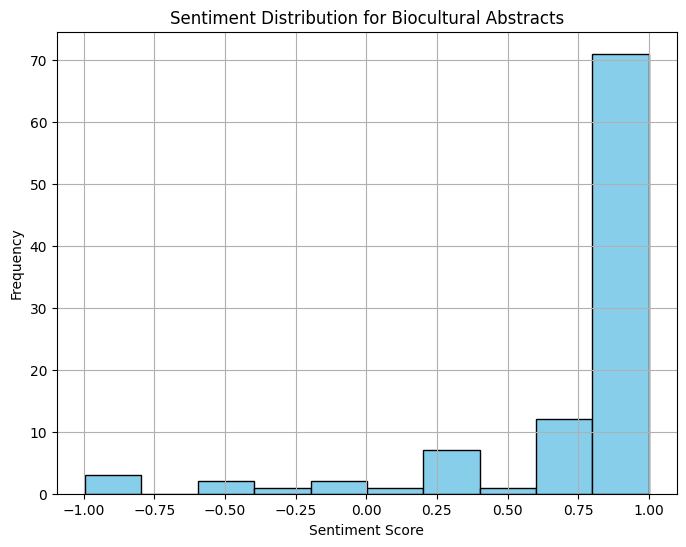

In [ ]:
# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(sentiments, bins=10, color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution for Biocultural Abstracts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Advancing your learning**: How would you apply this to the OpenAlex dataset?

* How would you apply the `SentimentIntensityAnalyzer` to the OpenAlex abstract data?
* What distribution of positive, negative, and neutral values do you see?
* What distribution of `compound score`s do you see?

## Conclusion

This tutorial covered fundamental NLP techniques such as term frequency, TF-IDF, n-grams, and sentiment analysis. These methods are essential tools in many text processing tasks, such as document classification, information retrieval, and opinion mining.